In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
#Paramètres pour l'affichage des graphes
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
#Helper, quelques fonctions qui nous seront utiles pour nos méthodes
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits import mplot3d


def laplace_solution(x, y, Lx, Ly):
    """
  
    x : numpy.ndarray
        The gridline locations in the x direction
        as a 1D array of floats.
    y : numpy.ndarray
        The gridline locations in the y direction
        as a 1D array of floats.
    Lx : float
        Length of the domain in the x direction.
    Ly : float
        Length of the domain in the y direction.
    Returns
    -------
    p : numpy.ndarray
        The analytical solution as a 2D array of floats.
    """
    X, Y = numpy.meshgrid(x, y)
    p = (numpy.sinh(1.5 * numpy.pi * Y / Ly) /
         numpy.sinh(1.5 * numpy.pi * Ly / Lx) *
         numpy.sin(1.5 * numpy.pi * X / Lx))
    return p


def poisson_solution(x, y, Lx, Ly):
    """
    Computes and returns the analytical solution of the Poisson equation
    on a given two-dimensional Cartesian grid.
    Parameters
    ----------
    x : numpy.ndarray
        The gridline locations in the x direction
        as a 1D array of floats.
    y : numpy.ndarray
        The gridline locations in the y direction
        as a 1D array of floats.
    Lx : float
        Length of the domain in the x direction.
    Ly : float
        Length of the domain in the y direction.
    Returns
    -------
    p : numpy.ndarray
        The analytical solution as a 2D array of floats.
    """
    X, Y = numpy.meshgrid(x, y)
    p = numpy.sin(numpy.pi * X / Lx) * numpy.cos(numpy.pi * Y / Ly)
    return p


def l2_norm(p, p_ref):
    """
    Computes and returns the relative L2-norm of the difference
    between a solution p and a reference solution p_ref.
    If L2(p_ref) = 0, the function simply returns
    the L2-norm of the difference.
    Parameters
    ----------
    p : numpy.ndarray
        The solution as an array of floats.
    p_ref : numpy.ndarray
        The reference solution as an array of floats.
    Returns
    -------
    diff : float
        The (relative) L2-norm of the difference.
    """
    l2_diff = numpy.sqrt(numpy.sum((p - p_ref)**2))
    l2_ref = numpy.sqrt(numpy.sum(p_ref**2))
    if l2_ref > 1e-12:
        return l2_diff / l2_ref
    return l2_diff


def poisson_2d_jacobi(p0, b, dx, dy, maxiter=20000, rtol=1e-6):
    """
    Solves the 2D Poisson equation for a given forcing term
    using Jacobi relaxation method.
    The function assumes Dirichlet boundary conditions with value zero.
    The exit criterion of the solver is based on the relative L2-norm
    of the solution difference between two consecutive iterations.
    Parameters
    ----------
    p0 : numpy.ndarray
        The initial solution as a 2D array of floats.
    b : numpy.ndarray
        The forcing term as a 2D array of floats.
    dx : float
        Grid spacing in the x direction.
    dy : float
        Grid spacing in the y direction.
    maxiter : integer, optional
        Maximum number of iterations to perform;
        default: 20000.
    rtol : float, optional
        Relative tolerance for convergence;
        default: 1e-6.
    Returns
    -------
    p : numpy.ndarray
        The solution after relaxation as a 2D array of floats.
    ite : integer
        The number of iterations performed.
    conv : list
        The convergence history as a list of floats.
    """
    p = p0.copy()
    conv = []  # convergence history
    diff = rtol + 1.0  # initial difference
    ite = 0  # iteration index
    while diff > rtol and ite < maxiter:
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, :-2] + pn[1:-1, 2:]) * dy**2 +
                          (pn[:-2, 1:-1] + pn[2:, 1:-1]) * dx**2 -
                          b[1:-1, 1:-1] * dx**2 * dy**2) /
                         (2.0 * (dx**2 + dy**2)))
        # Dirichlet boundary conditions at automatically enforced.
        # Compute and record the relative L2-norm of the difference.
        diff = l2_norm(p, pn)
        conv.append(diff)
        ite += 1
    return p, ite, conv


def plot_3d(x, y, p, label='$z$', elev=30.0, azim=45.0):
    """
    Creates a Matplotlib figure with a 3D surface plot of the scalar field p.
    Parameters
    ----------
    x : numpy.ndarray
        Gridline locations in the x direction as a 1D array of floats.
    y : numpy.ndarray
        Gridline locations in the y direction as a 1D array of floats.
    p : numpy.ndarray
        Scalar field to plot as a 2D array of floats.
    label : string, optional
        Axis label to use in the third direction;
        default: 'z'.
    elev : float, optional
        Elevation angle in the z plane;
        default: 30.0.
    azim : float, optional
        Azimuth angle in the x,y plane;
        default: 45.0.
    """
    fig = pyplot.figure(figsize=(8.0, 6.0))
    ax = mplot3d.Axes3D(fig)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel(label)
    X, Y = numpy.meshgrid(x, y)
    ax.plot_surface(X, Y, p, cmap=cm.viridis)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(y[0], y[-1])
    ax.view_init(elev=elev, azim=azim)


In [ ]:
#On voit directement que les solutions de cette équations sont des exponentielles de forme C*exp(k*x) où C et k sont des constantes
#on doit donc résoudre l'équation suivante :
# C*(k**4)*exp(k*x) - 5*C*(k**2)*exp(k*x) + 4*C*exp(k*x) = 0
#En simplifiant, on voit directement apparaitre une équation du second degré en k, en résolvant on trouve le spectre suivant pour k : 
# k = {-2, -1, 1, 2}. On a donc une solution générale pour notre équation : 
#f(x) = C[1]*exp(x) + C[2]*exp(-x) + C[3]*exp(2*x) + C[4]*exp(-2*x) où les C[i=1, 2, 3, 4] sont les constantes d'intégration qui seront discutées plus tard 

In [4]:
#On commence la discrétisation de notre domaine et la paramétrisation nécéssire à la suite du travail :
#On définit notre abscisse :
nx = 101  # nombre de points (entre x=0 et x=1)
Lx = 1.0  # domaine de définition
dx = Lx / (nx - 1)  #intervalle entre x[i] et x[i+1]

#BC :
a=0. #condition au bord (f(x = 0)
b=0. #                  (f'(x=0))
c=1. #                  (f(x=1))
d=-1. #                 (f'(x=1))

#On situe nos points sur la grille :
x = numpy.linspace(0.0, Lx, num=nx)

#Conditions initiales :
p0 = numpy.zeros(nx)
p0[-1] = c
print(p0)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1.]


In [5]:
#Les constantes d'intégration peuvent être déterminées en résolvant le système d'équation linéaire obtenu en appliquant les conditions aux bords
#Ces dernières vont dépendre des paramètres a, b, c et d. On définit donc une fonction qui va résoudre ce système pour n'importe quels paramètres aux bords
def resolvsyst (a,b,c,d):


    A = ([1,1,1,1],[1,-1,2,-2],[(numpy.exp(1)),(numpy.exp(-1)),(numpy.exp(2)),(numpy.exp(-2))],[(numpy.exp(1)),(-numpy.exp(-1)),(2*numpy.exp(2)),(-2*numpy.exp(-2))])
    A = numpy.array(A)
    t = numpy.array([a,b,c,d])
    y = numpy.linalg.solve(A,t)
    return y

In [6]:
#On résout ce système pour les paramètres donnés dans l'énoncé, et on obtient donc la solution exacte de l'équation pour ces paramètres aux bords
C = resolvsyst(0,0,1,-1)
pexact = C[0]*numpy.exp(x)+C[1]*numpy.exp(-x)+C[2]²*numpy.exp(2*x)+C[3]*numpy.exp(-2*x)

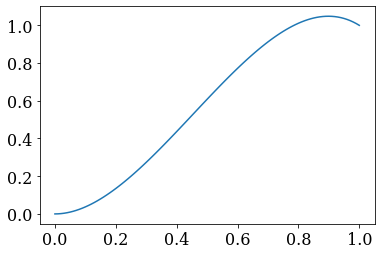

In [7]:
#On affiche cette fonction :
pyplot.plot(x,pexact)

In [8]:
#On va maintenant s'intéresser aux méthodes de résolution numériques pour les équations différentielles. Pour Gauss-Seidel, on importe un outil augmentant la vitesse de calcul :
import numba
from numba import jit

In [9]:
@jit(nopython=True)
def laplace_2d_gauss_seidel(dx,p0, maxiter=20000, rtol=1e-6):
    p = p0.copy()
    beta = 6+10*dx**2+4*dx**4
    gamma = -4-5*dx**2
    conv = []  # convergence history
    diff = rtol + 1.0  # initial difference
    ite = 0  # iteration index
    
    while diff > rtol and ite < maxiter:
        pn = p.copy()
        # Update the solution at interior points.
        for i in range(2,nx-2):
            p[i] = (1/beta)*(-p[i-2]-gamma*p[i-1]-gamma*p[i+1]-p[i+2])
        # Apply 2nd-order Neumann condition (zero-gradient)
        # at the right boundary.
                      
        p[-2]= p[-1]+dx
        p[1] = p[0]
        diff = numpy.sqrt(numpy.sum((p - pn)**2) / numpy.sum(pn**2))
        conv.append(diff)
        ite += 1 
    return p, ite, conv

In [10]:
#Le code tourne jusqu'à ce que la différence relative entre deux valeures successives de la fonction soit suffisement petite (on peut changer cette valeur dans le code ci haut).
#On veut ici savoir combien d'itérations ont été nécessaire pour arriver à une telle différence :
p, ites, conv_gs = laplace_2d_gauss_seidel(dx,p0,
                                           maxiter=20000000, rtol=1e-8)
print('Gauss-Seidel relaxation: {} iterations '.format(ites) +
      'to reach a relative difference of {}'.format(conv_gs[-1]))

Gauss-Seidel relaxation: 2531638 iterations to reach a relative difference of 9.99998581262672e-09


1.0 1.01


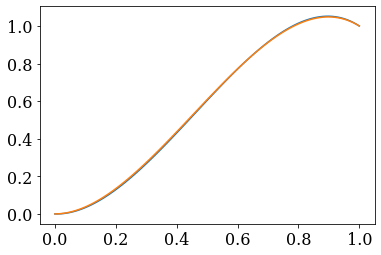

In [11]:
#Ici on compare graphiquement notre solution exacte (en orange) et la fonction obtenue par Gauss-Seidel (en bleu)
#On voit qu'elles sont pratiquement confondues, on a donc très bien apprché la solution avec cette méthode
print(p[-1],p[-2])
pyplot.plot(x,p)
pyplot.plot(x,pexact)

In [12]:
#Pour la suite on va réécrire la norme L_2 (ne n'est absolument pas nécessaire mais c'est plus simple pour nous)
def L2_rel_error(p, pk):
    return numpy.sqrt(numpy.sum((p - pk)**2)/numpy.sum(pk**2))
#On va maintenant tenter de résoudre avec la méthode du gradient conjugué :

In [17]:
def conjugate_gradient(p0, dx,
                       maxiter=20000, rtol=1e-7):
    #On va définir l'opérateur différentiel qui agit sur notre fonction en utilisant la finite central difference :
    def A(p):
        return ((p[:-4] - 4 * p[1:-3] + 6 * p[2:-2] - 4 * p[3:-1]  + p[4:]) / dx**4) - (5 * (p[1:-3] - 2 * p[2:-2] + p[3:-1]) / dx**2) + 4 * p[2:-2]
    p = p0.copy()
    r = numpy.zeros_like(p)  # on règle le résidus initial
    Ad = numpy.zeros_like(p)  # permet de multiplier les différentes quantités considérées
    conv = []  # convergence 
    diff = rtol + 1  # difference initiale
    ite = 0  # indexe d'itération. Comme pour Gauss, on veut connaitre le nombre d'itération décessaire à la résolution de notre équation
    # On compute le résidus initial. Ici il n'y a pas de terme de sources, l'équation est homogène. Notre fonction conjugate_gradient ne dépendra donc pas du paramètre b (comme il est défini dans le cours)
    r[2:-2] = - A(p)
    # On règle la rechere de direction initiale pour être le résidus
    d = r.copy()
    # On va maintenant run notre code. Celui ci ne s'arrêtera pas tant que le nombre d'itérations max ne soit atteint ou que la différence relative entre deux points successifs soit suffisement petite
    while diff > rtol and ite < maxiter:
        pk = p.copy()
        rk = r.copy()
        # Compute the Laplacian of the search direction.
        Ad[2:-2] = A(d)
        # Compute the step size.
        alpha = numpy.sum(r * r) / numpy.sum(d * Ad)
        # Update the solution.
        p = pk + alpha * d
        # Update the residual.
        r = rk - alpha * Ad
        # Update the search direction.
        beta = numpy.sum(r * r) / numpy.sum(rk * rk)
        d = r + beta * d
        # Dirichlet boundary conditions are automatically enforced.
        # VN condtitions
        p[-2]= p[-1]+dx
        p[1] = p[0]
        # Compute the relative L2-norm of the difference.
        diff =  L2_rel_error(p, pk)
        conv.append(diff)
        ite += 1
    return p, ite, conv

In [18]:
# Compute the solution using the method of conjugate gradients.
p, ites, conv_cg = conjugate_gradient(p0, dx, 
                                      maxiter=20000, 
                                      rtol=1e-10)
print('Method of conjugate gradients: {} iterations '.format(ites) +
      'to reach a relative difference of {}'.format(conv_cg[-1]))

Method of conjugate gradients: 304 iterations to reach a relative difference of 9.988569942171603e-11


In [19]:
l2_norm(p, pexact)

13.346526104853444

1.0 1.01


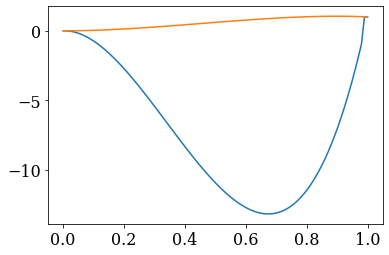

In [20]:
print(p[-1],p[-2])
pyplot.plot(x,p)
pyplot.plot(x,pexact)